# Particle swarm optimization of a bullseye cavity for quantum emitter light extraction

**Note: the cost of running the entire notebook is higher than 15 FlexCredit.**

A bullseye cavity is characterized by concentric rings of alternating dielectrics, resembling a bullseye target. It has been successfully employed to enhance the collection efficiency and decay rate of various quantum emitters, including quantum dots, defect centers in diamond, and 2D materials.

In this notebook, we show how to set up a bullseye cavity simulation using Tidy3D and use Particle Swarm Optimization (PSO) to enhance the coupling efficiency from quantum emitters into the fundamental mode of an optical fiber. We will use the free available python library [`PySwarms`](https://pyswarms.readthedocs.io/en/latest/index.html) for running PSO. For details about PSO you can see the notebook [Particle swarm optimization of a polarization beam splitter](../notebooks/ParticleSwarmOptimizedPBS.html). In addition, we show how to calculate the cavity Purcell factor, which is another important figure-of-merit within the context of cavity electrodynamics.

Let's start by importing the python libraries used throughout this notebook.

In [1]:
# Standard python imports.
import numpy as np
import matplotlib.pylab as plt
from pyswarms.single.global_best import GlobalBestPSO

# Import regular tidy3d.
import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins.mode import ModeSolver
from tidy3d.plugins.mode.web import run as run_mode_solver

## Cavity Geometry and Simulation Parameters

The cavity structure is inspired in `Hekmati, R., Hadden, J.P., Mathew, A. et al. Bullseye dielectric cavities for photon collection from a surface-mounted quantum-light-emitter. Sci Rep 13, 5316 (2023)` [DOI: 10.1038/s41598-023-32359-0](https://doi.org/10.1038/s41598-023-32359-0), where the authors presented a $TiO_{2}$ over $SiO_{2}$ bullseye cavity. In that work, the cavity was designed to enhance the emission from point sources, such as $WSe_{2}$ flakes, single dye molecules, and nano-diamonds, positioned just above the centre of the structure. It was optimized using an iterative approach to enhance the power coupling into the numerical aperture (NA) of free-space optics and a low NA fiber.

Differently from that work, here we will set up the optimization to enhance the modal coupling efficiency of the generated photons into the collection fiber. When building an optimization scheme for practical applications, more advanced optimization strategies can be implemented to include other quantities of interest—for instance, the Purcell factor, which is important within the context of devices such as single-photon sources. The following figure shows the main cavity geometric parameters.

<img src="img/bullseye_psa_diagram.png" alt="Bullseye Cavity Diagram"  width="800"/>

In [2]:
# Initial parameters of the Bullseye cavity.
t_tio2 = 0.200  # TiO2 thin film thickness (um).
t_sio2 = 0.435  # SiO2 thin film thickness (um).
r_cav = 0.835  # Radius of the internal cavity (um).
p_bragg = 0.420  # Period of the Bragg reflector (um).
w_bragg = 0.155  # Gap width (etched region) of the Bragg reflector (um).
n_bragg = 8  # Number of Bragg periods.
n_tio2 = 2.50  # TiO2 refractive index (0.75 um).
n_sio2 = 1.45  # SiO2 refractive index (0.75 um).

# Collection fiber parameters (630HP).
r_core = 1.75  # Fiber core radius.
n_core = 1.46  # Core refractive index.
n_clad = 1.45  # Cladding refractive index.
d_cf = 2.0  # Distance between the cavity and the fiber.

# PSO optimization parameters.
iterations = 30  # Number of iterations.
n_particle = 5  # Number of particles in optimization.

# Simulation wavelength.
wl = 0.75  # Central simulation wavelength (um).
bw = 0.06  # Simulation bandwidth (um).
n_wl = 61  # Number of wavelength points within the bandwidth.

From the parameters defined before, a lot of variables are computed and used to set up the optimization.

In [3]:
# Wavelengths and frequencies.
wl_max = wl + bw / 2
wl_min = wl - bw / 2
wl_range = np.linspace(wl_min, wl_max, n_wl)
freq = td.C_0 / wl
freqs = td.C_0 / wl_range
freqw = 0.5 * (freqs[0] - freqs[-1])
run_time = 5e-12  # Simulation run time.

# Material definition.
mat_tio2 = td.Medium(permittivity=n_tio2 ** 2)  # TiO2 medium.
mat_sio2 = td.Medium(permittivity=n_sio2 ** 2)  # SiO2 medium.
mat_etch = td.Medium(permittivity=1)  # Etch medium.
mat_core = td.Medium(permittivity=n_core ** 2)  # Fiber core medium.
mat_clad = td.Medium(permittivity=n_clad ** 2)  # Fiber cladding medium.

# Computational domain size.
pml_spacing = 0.6 * wl
eff_inf = 10

## Bullseye Cavity Set Up

We start with the definition of a function to build the bullseye cavity simulation. The PSO algorithm passes 6 parameters to this function, which in turn returns a simulation object. The quantum emitter is modeled as a y-oriented `PointDipole` placed at the top of the cavity surface. A `ModeMonitor` calculates the power coupled into the fiber fundamental mode, and a `FluxMonitor` gets the total dipole power. We are using a `PECBoundary` condition in the -**z** direction as a metallic reflector at the bottom of the $SiO_{2}$ layer.

In [4]:
def get_simulation(
    r=r_cav,  # Cavity radius.
    p=p_bragg,  # Cavity period.
    w=w_bragg,  # Etched width.
    h=0.0,  # Non-etched thickness with respect to TiO2 thickness.
    tsio2=t_sio2,  # SiO2 layer thickness.
    dcf=d_cf,  # Cavity to fiber distance.
):

    # Computational domain size.
    size_x = 2 * pml_spacing + max(2 * (r + n_bragg * p), 2 * r_core)
    size_y = size_x
    size_z = pml_spacing + tsio2 + t_tio2 + dcf
    center_z = -size_z / 2
    qd_pos_z = tsio2 + t_tio2
    mon_pos_z = size_z - pml_spacing / 2

    # Point dipole source located at the center of TiO2 thin film.
    dp_source = td.PointDipole(
        center=(0, 0, qd_pos_z),
        source_time=td.GaussianPulse(freq0=freq, fwidth=freqw),
        polarization="Ey",
    )

    # Field monitor to visualize the fields in xy plane.
    field_monitor_xy = td.FieldMonitor(
        center=(0, 0, qd_pos_z - t_tio2 / 2),
        size=(size_x, size_y, 0),
        freqs=[freq],
        name="field_xy",
    )

    # Field monitor to visualize the fields in xz plane.
    field_monitor_xz = td.FieldMonitor(
        center=(0, 0.05, size_z / 2),
        size=(size_x, 0, size_z),
        freqs=[freq],
        name="field_xz",
    )

    # Mode monitor to get the power coupled into the fiber modes.
    mode_spec = td.ModeSpec(num_modes=1, target_neff=n_core)
    mode_monitor = td.ModeMonitor(
        center=(0, 0, mon_pos_z),
        size=(size_x, size_y, 0),
        freqs=freqs,
        mode_spec=mode_spec,
        name="mode_fiber",
    )

    # Flux monitor to get the total dipole power.
    flux_dip = td.FluxMonitor(
        center=(0, 0, size_z / 2),
        size=(size_x, size_y, size_z),
        freqs=freqs,
        exclude_surfaces=("z-",),
        name="flux_dip",
    )

    # Silicon dioxide layer
    sio2_layer = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(-size_x / 2 - eff_inf, -size_y / 2 - eff_inf, -eff_inf),
            rmax=(size_x / 2 + eff_inf, size_y / 2 + eff_inf, tsio2),
        ),
        medium=mat_sio2,
    )

    # Fiber cladding
    fiber_clad = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(-size_x / 2 - eff_inf, -size_y / 2 - eff_inf, size_z - pml_spacing),
            rmax=(size_x / 2 + eff_inf, size_y / 2 + eff_inf, size_z + eff_inf),
        ),
        medium=mat_clad,
    )

    # Fiber core
    fiber_core = td.Structure(
        geometry=td.Cylinder(
            radius=r_core,
            center=(0, 0, size_z + (((pml_spacing + eff_inf) / 2) - pml_spacing)),
            axis=2,
            length=pml_spacing + eff_inf,
        ),
        medium=mat_core,
    )

    # Bullseye cavity
    bullseye = []
    cyl_rad = n_bragg * p + r
    for _ in range(0, n_bragg):
        bullseye.append(
            td.Structure(
                geometry=td.Cylinder(
                    radius=cyl_rad,
                    center=(0, 0, qd_pos_z - t_tio2 / 2),
                    axis=2,
                    length=t_tio2,
                ),
                medium=mat_tio2,
            )
        )
        bullseye.append(
            td.Structure(
                geometry=td.Cylinder(
                    radius=cyl_rad - p + w,
                    center=(0, 0, qd_pos_z - t_tio2 / 2),
                    axis=2,
                    length=t_tio2,
                ),
                medium=mat_etch,
            )
        )
        cyl_rad -= p

    bullseye.append(
        td.Structure(
            geometry=td.Cylinder(
                radius=r, center=(0, 0, qd_pos_z - t_tio2 / 2), axis=2, length=t_tio2
            ),
            medium=mat_tio2,
        )
    )
    # Non-etched TiO2 region.
    if h > 0:
        bullseye.append(
            td.Structure(
                geometry=td.Box.from_bounds(
                    rmin=(-size_x / 2 - eff_inf, -size_y / 2 - eff_inf, tsio2),
                    rmax=(
                        size_x / 2 + eff_inf,
                        size_y / 2 + eff_inf,
                        tsio2 + h * t_tio2,
                    ),
                ),
                medium=mat_tio2,
            )
        )

    # Simulation definition
    sim = td.Simulation(
        center=(0, 0, -center_z),
        size=(size_x, size_y, size_z),
        medium=mat_etch,
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=15, wavelength=wl),
        structures=[sio2_layer, fiber_clad, fiber_core] + bullseye,
        sources=[dp_source],
        normalize_index=0,
        monitors=[field_monitor_xy, field_monitor_xz, mode_monitor, flux_dip],
        boundary_spec=td.BoundarySpec(
            x=td.Boundary.pml(),
            y=td.Boundary.pml(),
            z=td.Boundary(minus=td.PECBoundary(), plus=td.PML()),
        ),
        symmetry=(1, -1, 0),
        run_time=run_time,
    )
    return sim

Let's visualize the simulation set up and verify if all the elements are in their correct places.

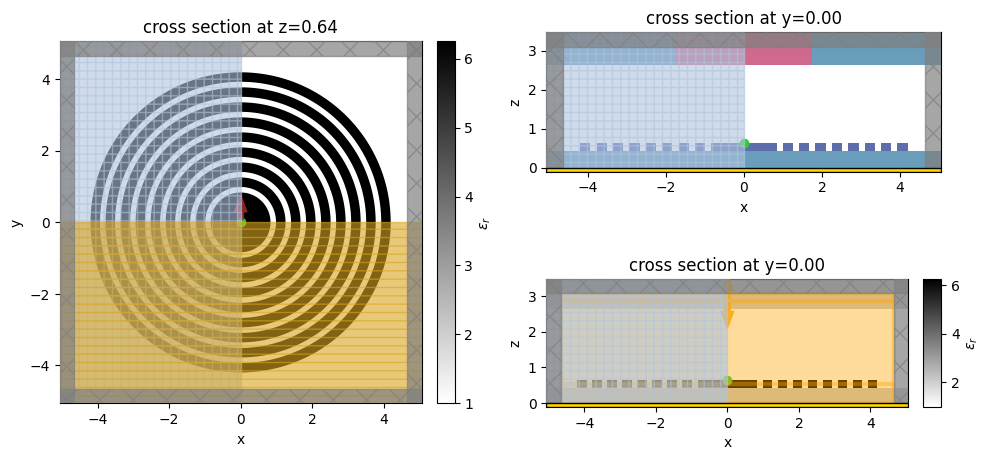

In [5]:
init_design = get_simulation()

fig = plt.figure(tight_layout=True, figsize=(10, 5))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])
init_design.plot_eps(z=t_sio2 + t_tio2, ax=ax1, monitor_alpha=0)
init_design.plot(y=0, ax=ax2, monitor_alpha=0)
init_design.plot_eps(y=0, ax=ax3)
plt.show()

## Output Fiber Mode

Before running the optimization, we will make sure the correct optical fiber mode has been considered.

In [6]:
mode_spec = td.ModeSpec(num_modes=1, target_neff=n_core)
mode_solver = ModeSolver(
    simulation=init_design,
    plane=td.Box(
        center=(0, 0, 0.5 * pml_spacing + t_sio2 + t_tio2 + d_cf),
        size=(td.inf, td.inf, 0),
    ),
    mode_spec=mode_spec,
    freqs=[freq],
)
mode_fiber = run_mode_solver(mode_solver)

[12:31:18] Mode solver created with                                    ]8;id=919539;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/plugins/mode/web.py\web.py]8;;\:]8;id=167499;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/plugins/mode/web.py#80\80]8;;\
           task_id='fdve-1016eae2-7d16-4e91-8e05-cc690a65b426v1',               
           solver_id='mo-dd2eb55c-59d8-4c37-9809-cebf450ed59b'.                 

Output()

Output()

[12:31:22] Mode solver status: queued                                  ]8;id=456034;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/plugins/mode/web.py\web.py]8;;\:]8;id=856580;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/plugins/mode/web.py#93\93]8;;\

[12:31:27] Mode solver status: running                                 ]8;id=30767;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/plugins/mode/web.py\web.py]8;;\:]8;id=616791;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/plugins/mode/web.py#93\93]8;;\

[12:31:48] Mode solver status: success                                ]8;id=692892;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/plugins/mode/web.py\web.py]8;;\:]8;id=770374;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/plugins/mode/web.py#103\103]8;;\

Output()

We can see the y-oriented fundamental optical fiber mode, as desired.

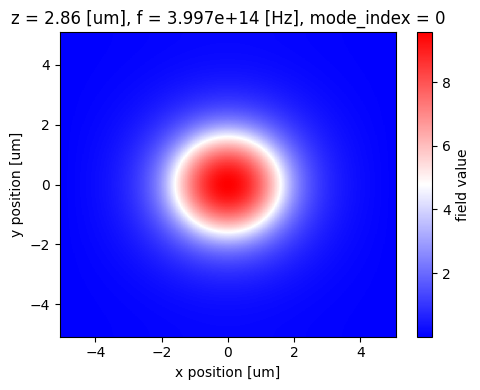

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
mode_fiber.Ey.real.sel(mode_index=0, f=freq).plot(x="x", y="y", cmap="bwr", ax=ax)
plt.show()

## Particle Swarm Optimization


The figure-of-merit used in the optimization is the coupling efficiency of generated photons into the fundamental optical mode of the collection fiber. We need to normalize the modal power by the dipole power to obtain the correct value, as below.

In [8]:
# Figure of Merit (FOM) calculation.
def get_coupling_eff(sim_data: td.SimulationData) -> float:
    """Return the power at the mode index of interest."""
    mode_amps = sim_data["mode_fiber"].amps.sel(direction="+", mode_index=0)
    mode_power = np.squeeze(np.abs(mode_amps) ** 2)
    dip_power = sim_data["flux_dip"].flux
    return mode_power / dip_power

Now, we can define the objective function passed to the PSO algorithm. This function receives a `(n_particles, dimensions)` array, where `n_particles` is the number of particles the optimization algorithm will move throughout the parameter space, and `dimensions` are the degrees of freedom (6). The `n_particles` simulations are submitted at once to the Tidy3D cloud, thus reducing the total optimization considerably.

In [9]:
def obj(x, verbose: bool = False) -> float:
    # Objective values for each particle.
    obj_val = []

    # Create a simulation batch to run all the particles at once.
    sim_batch = {
        f"sim_r:{r}_p:{p}_w:{w}_h:{h}_t:{t}_d:{d}": get_simulation(
            r=r, p=p, w=w, h=h, tsio2=t, dcf=d
        )
        for r, p, w, h, t, d in zip(
            x[:, 0], x[:, 1], x[:, 2], x[:, 3], x[:, 4], x[:, 5]
        )
    }

    # Run the simulation batch.
    batch_data = web.run_async(simulations=sim_batch, path_dir="data", verbose=verbose)

    # Get the results.
    for _, sim_data in batch_data.items():
        ce = get_coupling_eff(sim_data)
        ce = np.amax(ce)
        obj_val.append(-ce)

    return np.asarray(obj_val)

Before starting the optimization, we need to define the bounds for the optimization parameters. Initial conditions are optional but necessary if results reproducibility is a concern. 

In [10]:
x_max = np.asarray(
    [1.5 * r_cav, 1.5 * p_bragg, 1.5 * w_bragg, 1.0, 1.5 * t_sio2, 1.5 * d_cf]
)
x_min = np.asarray(
    [0.5 * r_cav, 0.5 * p_bragg, 0.5 * w_bragg, 0.0, 0.5 * t_sio2, 0.5 * d_cf]
)
bounds = (x_min, x_max)

# Initial parameters
np.random.seed(123)
init_par = np.random.uniform(0.5, 1.0, (n_particle, x_max.shape[0]))
init_par[:, 0] = init_par[:, 0] * r_cav
init_par[:, 1] = init_par[:, 1] * p_bragg
init_par[:, 2] = init_par[:, 2] * w_bragg
init_par[:, 3] = init_par[:, 3] - 0.5
init_par[:, 4] = init_par[:, 4] * t_sio2
init_par[:, 5] = init_par[:, 5] * d_cf

# Initialization of PSO global optimizer.
options = {"c1": 0.5, "c2": 0.3, "w": 0.9}
optimizer = GlobalBestPSO(
    n_particles=n_particle,
    dimensions=x_max.shape[0],
    options=options,
    bounds=bounds,
    init_pos=init_par,
)

Now, we are ready to run the optimization!

In [11]:
# Run the optimization.
best_ce, best_par = optimizer.optimize(obj, iterations)
best_ce = np.abs(best_ce)

2023-09-19 12:32:15,752 - pyswarms.single.global_best - INFO - Optimize for 30 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|30/30, best_cost=-.397
2023-09-19 14:30:39,176 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.3974066414798787, best pos: [0.51796414 0.40680774 0.12680785 0.23418567 0.28031486 1.58226138]


In the end, we can obtain the optimized cavity parameters and see how the optimization has evolved into the final value. We have obtained a 4-fold improvement in coupling efficiency along the optimization. When optimizing a device aiming practical applications, one can consider to add more particles, increase the number of iterations, or trying different meta parameters to improve results further.

Best parameters:
r_cav = 0.518 um
p_bragg = 0.407 um
w_bragg = 0.127 um
h = 0.234
t_sio2 = 0.280 um
d_cf = 1.582 um


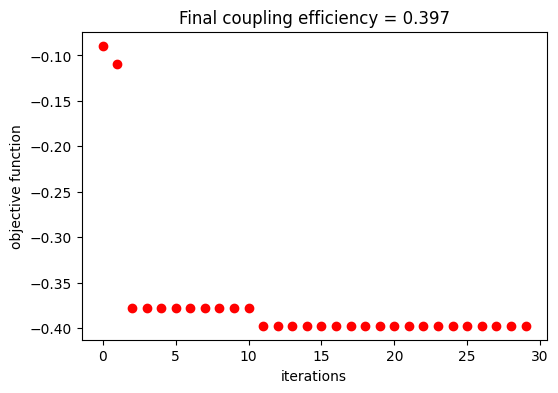

In [12]:
print(f"Best parameters:")
print(f"r_cav = {best_par[0]:.3f} um")
print(f"p_bragg = {best_par[1]:.3f} um")
print(f"w_bragg = {best_par[2]:.3f} um")
print(f"h = {best_par[3]:.3f}")
print(f"t_sio2 = {best_par[4]:.3f} um")
print(f"d_cf = {best_par[5]:.3f} um")

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(optimizer.cost_history, "ro")
ax.set_xlabel("iterations")
ax.set_ylabel("objective function")
ax.set_title(f"Final coupling efficiency = {best_ce:.3f}")
plt.show()

## Final Bullseye Cavity

Now, we can simulate the optimized bullseye cavity and take a look at the coupling efficiency along the whole bandwidth.

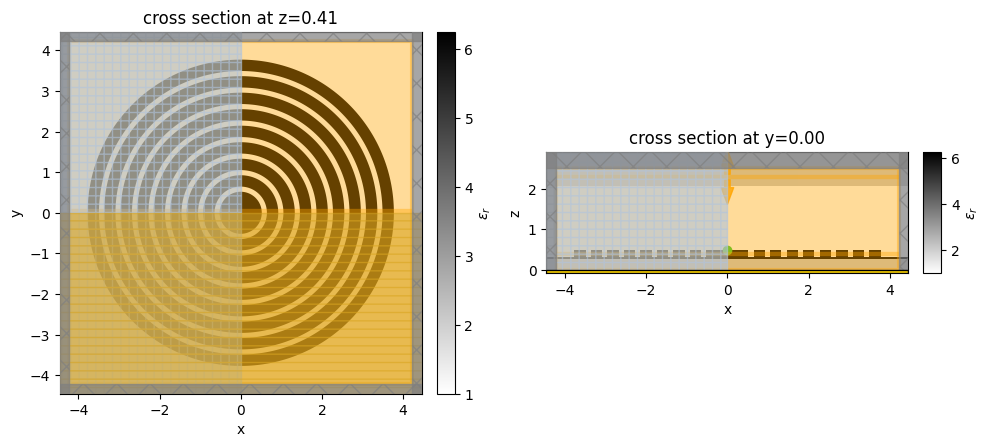

In [13]:
final_design = get_simulation(
    r=best_par[0],
    p=best_par[1],
    w=best_par[2],
    h=best_par[3],
    tsio2=best_par[4],
    dcf=best_par[5],
)

fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 5))
final_design.plot_eps(z=best_par[4] + t_tio2 / 1.5, ax=ax1)
final_design.plot_eps(y=0, ax=ax2)
plt.show()

In [14]:
sim_data_final = web.run(final_design, task_name="final bullseye")

[14:30:39] Created task 'final bullseye' with task_id              ]8;id=957396;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=890954;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-e0427082-157e-4850-829b-0131fc7f5deev1'.                       

           View task using web UI at                               ]8;id=378498;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=93774;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=465355;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e0427082-157e-4850-829b-0131fc7f5deev1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=24935;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e0427082-157e-4850-829b-0131fc7f5deev1\taskId]8;;\]8;id=465355;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e0427082-157e-4850-829b-0131fc7f5deev1\=]8;;\]8;id=199394;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e0427082-157e-4850-829b-0131fc7f5deev1\fdve]8;;\]8;id=465355;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e0427082-157e-4850-829b-0131fc7f5deev1\-]8;;\              
           ]8;id=465355;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e0427082-157e-4850-829b-0131fc7f5deev1\e0427082-157e-4850-829b-0131fc7f5deev1']8;;\.                             

Output()

[14:30:42] status = queued                                         ]8;id=174039;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=523862;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py#361\361]8;;\

Output()

[14:30:47] status = preprocess                                     ]8;id=519670;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=198281;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py#355\355]8;;\

[14:30:52] Maximum FlexCredit cost: 0.341. Use                     ]8;id=382918;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=851467;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py#341\341]8;;\
           'web.real_cost(task_id)' to get the billed FlexCredit                
           cost after a simulation run.                                         

           starting up solver                                      ]8;id=74936;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=248505;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py#377\377]8;;\

[14:30:53] running solver                                          ]8;id=691036;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=791853;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py#386\386]8;;\

           To cancel the simulation, use 'web.abort(task_id)' or   ]8;id=370473;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=24305;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py#387\387]8;;\
           'web.delete(task_id)' or abort/delete the task in the                
           web UI. Terminating the Python script will not stop the              
           job running on the cloud.                                            

Output()

[14:31:43] early shutoff detected, exiting.                        ]8;id=98953;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=334674;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py#404\404]8;;\

[14:31:44] status = postprocess                                    ]8;id=8217;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=813764;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py#420\420]8;;\

Output()

[14:32:47] status = success                                        ]8;id=50112;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=36959;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py#427\427]8;;\

Output()

[14:32:54] loading SimulationData from simulation_data.hdf5        ]8;id=880721;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=926634;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py#591\591]8;;\


The peak coupling efficiency is about 40% at 0.725 $\mu m$.

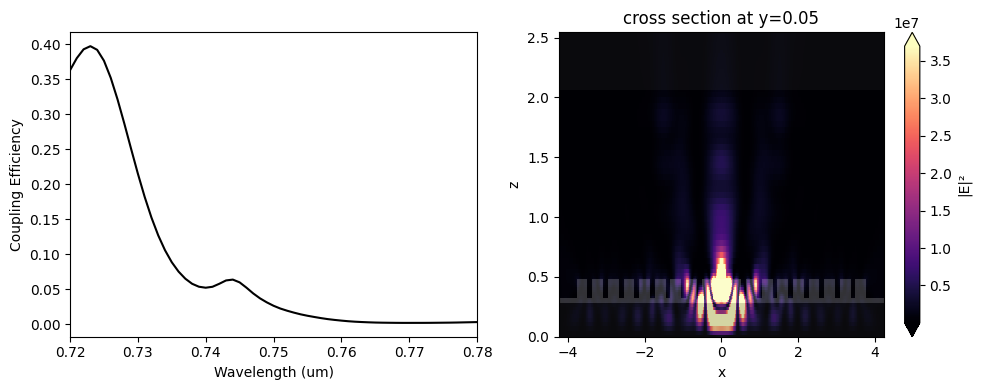

In [15]:
coup_eff = get_coupling_eff(sim_data_final)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
ax1.plot(wl_range, coup_eff, "-k")
ax1.set_xlabel("Wavelength (um)")
ax1.set_ylabel("Coupling Efficiency")
ax1.set_xlim(wl - bw / 2, wl + bw / 2)
sim_data_final.plot_field("field_xz", "E", "abs^2", ax=ax2)
ax2.set_aspect("auto")
plt.show()

## Purcell Factor Calculation

Purcell factor enhancement is usually desired when designing a quantum emitter light extractor device, as it can lead to higher photon generation rates, $\beta$-factors, and photon indistinguishability. Next, we calculate the bullseye nanocavity Purcell factor ($F_{p} = P_{cav}/P_{bulk}$) defined as the ratio between the dipole power emitted in bulk semiconductor and the final device.

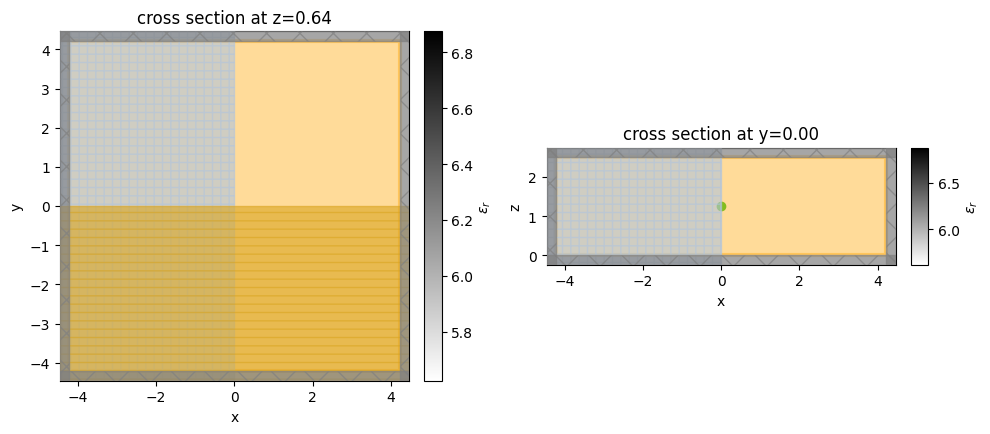

In [16]:
# Point dipole source located at the center of TiO2 thin film.
dp_source_bulk = td.PointDipole(
    center=(0, 0, (pml_spacing + best_par[4] + t_tio2 + best_par[5]) / 2),
    source_time=td.GaussianPulse(freq0=freq, fwidth=freqw),
    polarization="Ey",
)

# Flux monitor to get the total dipole power.
flux_dip_bulk = td.FluxMonitor(
    center=(0, 0, (pml_spacing + best_par[4] + t_tio2 + best_par[5]) / 2),
    size=(final_design.size),
    freqs=freqs,
    name="flux_dip_bulk",
)

bulk_device = final_design.copy(
    update={
        "structures": [],
        "sources": [dp_source_bulk],
        "monitors": [flux_dip_bulk],
        "medium": mat_tio2,
        "boundary_spec": td.BoundarySpec.all_sides(boundary=td.PML()),
    }
)

fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 5))
bulk_device.plot_eps(z=t_sio2 + t_tio2, ax=ax1)
bulk_device.plot_eps(y=0, ax=ax2)
plt.show()

In [17]:
sim_data_bulk = web.run(bulk_device, task_name="bulk sim")

[14:35:29] Created task 'bulk sim' with task_id                    ]8;id=835519;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=607571;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-45e25cb5-69aa-4953-93f9-d0a48cec7705v1'.                       

           View task using web UI at                               ]8;id=484708;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=620543;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=701325;https://tidy3d.simulation.cloud/workbench?taskId=fdve-45e25cb5-69aa-4953-93f9-d0a48cec7705v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=775046;https://tidy3d.simulation.cloud/workbench?taskId=fdve-45e25cb5-69aa-4953-93f9-d0a48cec7705v1\taskId]8;;\]8;id=701325;https://tidy3d.simulation.cloud/workbench?taskId=fdve-45e25cb5-69aa-4953-93f9-d0a48cec7705v1\=]8;;\]8;id=819173;https://tidy3d.simulation.cloud/workbench?taskId=fdve-45e25cb5-69aa-4953-93f9-d0a48cec7705v1\fdve]8;;\]8;id=701325;https://tidy3d.simulation.cloud/workbench?taskId=fdve-45e25cb5-69aa-4953-93f9-d0a48cec7705v1\-]8;;\              
           ]8;id=701325;https://tidy3d.simulation.cloud/workbench?taskId=fdve-45e25cb5-69aa-4953-93f9-d0a48cec7705v1\45e25cb5-69aa-4953-93f9-d0a48cec7705v1']8;;\.                             

Output()

[14:35:33] status = queued                                         ]8;id=233935;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=221071;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py#361\361]8;;\

Output()

[14:35:37] status = preprocess                                     ]8;id=158909;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=353215;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py#355\355]8;;\

[14:35:43] Maximum FlexCredit cost: 0.439. Use                     ]8;id=533290;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=741782;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py#341\341]8;;\
           'web.real_cost(task_id)' to get the billed FlexCredit                
           cost after a simulation run.                                         

           starting up solver                                      ]8;id=450643;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=250496;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py#377\377]8;;\

           running solver                                          ]8;id=501296;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=964668;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py#386\386]8;;\

           To cancel the simulation, use 'web.abort(task_id)' or   ]8;id=336711;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=955010;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py#387\387]8;;\
           'web.delete(task_id)' or abort/delete the task in the                
           web UI. Terminating the Python script will not stop the              
           job running on the cloud.                                            

Output()

[14:35:56] early shutoff detected, exiting.                        ]8;id=477682;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=924503;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py#404\404]8;;\

           status = postprocess                                    ]8;id=745888;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=141446;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py#420\420]8;;\

Output()

[14:35:58] status = success                                        ]8;id=635122;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=541827;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py#427\427]8;;\

Output()

[14:36:01] loading SimulationData from simulation_data.hdf5        ]8;id=972477;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=740952;file:///home/emerson/miniconda3/envs/tidy3d_2.4.0/lib/python3.11/site-packages/tidy3d/web/webapi.py#591\591]8;;\

A maximum Purcell value of about 3.7 is achieved at 0.73 $\mu m$, even though this figure-of-merit was not pursued along the optimization. Higher Purcell values can be obtained in cases where the quantum emitter can be embedded within the cavity material.

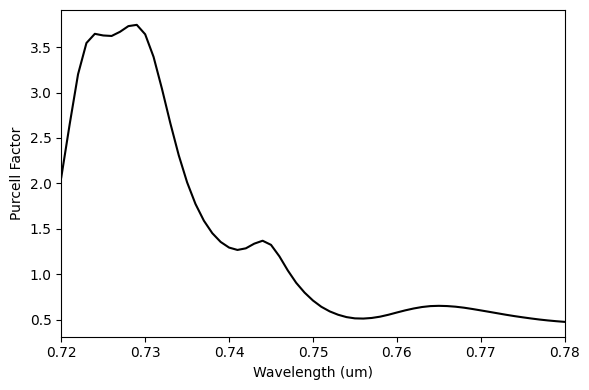

In [18]:
p_cav = sim_data_final["flux_dip"].flux
p_bulk = sim_data_bulk["flux_dip_bulk"].flux
purcell = p_cav / p_bulk

f, ax1 = plt.subplots(1, 1, figsize=(6, 4), tight_layout=True)
ax1.plot(wl_range, purcell, "-k")
ax1.set_xlabel("Wavelength (um)")
ax1.set_ylabel("Purcell Factor")
ax1.set_xlim(wl - bw / 2, wl + bw / 2)
plt.show()